In [1]:
#!pip install parse
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np

import gamma
from gamma import *
from gamma.torch import *
from gamma.models import *

In [2]:
TF_DIMS = {
    'act': 'NHWC',
    2: ('in_channels', 'out_channels'),
    4: ('kh', 'kw', 'in_channels', 'out_channels')
}

TORCH_DIMS = {
    'act': 'NCHW',
    2: ('out_channels', 'in_channels'),
    4: ('out_channels', 'in_channels', 'kh', 'kw')
}

transpose = lambda x, input_dims, output_dims: x.transpose([input_dims.index(d) for d in output_dims])

def state_dict_from_ckpt(ckpt_name):
    from tensorflow.python import pywrap_tensorflow
    reader = pywrap_tensorflow.NewCheckpointReader(ckpt)
    return {k: reader.get_tensor(k) for k in reader.get_variable_to_shape_map().keys()}

def depthwise_to_grouped_conv(weights):
    kh, kw, in_channels, depth_mult = weights.shape
    return weights.reshape((kh, kw, 1, in_channels*depth_mult))

def tf_to_torch(state_dict):
    res = ((k, (depthwise_to_grouped_conv(v) if ('depthwise_weights' in k) else v)) for (k,v) in state_dict.items())
    res = ((k, (np.array(v) if not isinstance(v, np.ndarray) else v)) for (k, v) in res)
    res = ((k, (transpose(v, TF_DIMS[v.ndim], TORCH_DIMS[v.ndim]) if (v.ndim > 1) else v)) for (k,v) in res)
    return {k: torch.from_numpy(v) for (k,v) in res}

def tf_to_torch_name_rules(use_ema=False):
    sfx = '/ExponentialMovingAverage' if use_ema else ''
    return [     
        ('{}/BatchNorm/beta'+sfx,        '{}/bn/bias'),
        ('{}/BatchNorm/gamma'+sfx,       '{}/bn/weight'),
        ('{}/BatchNorm/moving_mean',     '{}/bn/running_mean'),
        ('{}/BatchNorm/moving_variance', '{}/bn/running_var'),

        ('{}/weights'+sfx,            '{}/conv/weight'),
        ('{}/depthwise_weights'+sfx,  '{}/conv/weight'),
        ('{}/biases'+sfx,             '{}/conv/bias'),
    ]

#### 1. Load pre-trained weights 

In [3]:
model_name = 'mobilenet_v2_1.0_224'
url = f'https://storage.googleapis.com/mobilenet_v2/checkpoints/{model_name}.tgz'
fname = gamma.utils.get_file(url)
ckpt = f'{fname}/{model_name}.ckpt'
use_ema = True

In [4]:
state_dict = tf_to_torch(state_dict_from_ckpt(ckpt))

M2 = 'MobilenetV2/'
rules = [
    (M2+'Conv/{}',                        'prep/conv_1/{}'),    
    (M2+'expanded_conv/depthwise/{}',     'prep/conv_2/{}'),    
    (M2+'expanded_conv/project/{}',       'prep/conv_3/{}'),    
    (M2+'expanded_conv_{i}/expand/{}',    'block_{i}/conv_1/{}'),
    (M2+'expanded_conv_{i}/depthwise/{}', 'block_{i}/conv_2/{}'),
    (M2+'expanded_conv_{i}/project/{}',   'block_{i}/conv_3/{}'),
    
    (M2+'Conv_1/{}',                      'classifier/expand/{}'),
    (M2+'Logits/Conv2d_1c_1x1/conv/{}',   'classifier/fc/{}'),
]

state_dict = rename(state_dict, tf_to_torch_name_rules(use_ema))
state_dict = rename(state_dict, rules)
state_dict['classifier/fc/weight'].squeeze_(); #this conv is applied to a 1x1 activation so equivalent to a nn.Linear layer

state = {n: (constant(v, size=v.shape), []) for n, v in state_dict.items()}
draw(state, direction='TB')

#### 2. Network description

In [5]:
net_initial, rules, net = mobilenetV2(num_classes=1001)

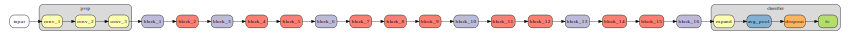

In [6]:
draw(net_initial)

In [7]:
draw(net)

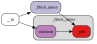

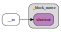

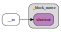

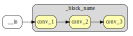

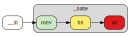

In [8]:
for r in rules: draw(r)

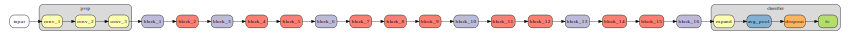

In [9]:
n = apply_rules(net, [reverse(rule) for rule in reversed(rules)])
draw(n)

#### 3. Extra rules to match tf

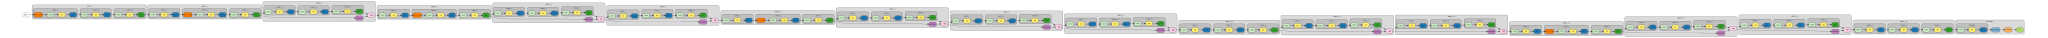

In [10]:
zero_pad = node_def(nn.ZeroPad2d)
@bind_vars
def match_tf_padding(name, in_channels, out_channels, kernel_size, groups, _in):
    LHS = {path(name, 'conv'): (conv(in_channels, out_channels, kernel_size, stride=2, padding=1, 
                groups=groups, bias=False), [_in])}
    RHS = pipeline([
        ('zero_pad', zero_pad((0,1,0,1)), [_in]),
        ('conv', conv(in_channels, out_channels, kernel_size, stride=2, padding=0, groups=groups, bias=False))
    ], prefix=name)
    return LHS, RHS


@bind_vars
def match_tf_bn_defaults(name, num_features, eps, _in):
    LHS = {name: (bn(num_features, eps=1e-5), [_in])}
    RHS = {name: (bn(num_features, eps=1e-3), [_in])}
    return LHS, RHS


net = apply_rules(net, [match_tf_padding(), match_tf_bn_defaults()])
draw(net)

#### 4. Build torch module and load weights

In [11]:
torch_net = apply_rules(net, torch_rules())
model = TorchGraph(torch_net).eval()
load_state(model, state_dict)

#### 5. Test

In [12]:
assert(use_ema)
import tensorflow as tf
inputs = np.random.rand(2, 224, 224, 3).astype(np.float32)

torch_inputs = {'input': torch.from_numpy(transpose(inputs, TF_DIMS['act'], TORCH_DIMS['act']))}
torch_outputs = model(torch_inputs)

gd = tf.GraphDef.FromString(open(f'{fname}/{model_name}_frozen.pb', 'rb').read())
inp, logits = tf.import_graph_def(gd,  return_elements = ['input:0', 'MobilenetV2/Logits/Squeeze:0'])
with tf.Session(graph=inp.graph):
    x = logits.eval(feed_dict={inp: inputs})
    
np.testing.assert_almost_equal(x, to_numpy(torch_outputs['classifier/fc']), decimal=4)
print('Success!')

Success!
